# Données

In [1]:
import os
import requests
from scipy.io import loadmat
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np

def get_mnist(): 
    mnist = fetch_openml('mnist_784')
    X = mnist['data']
    X = (mnist['data'] > 128).astype(int)
    y = mnist['target']
    y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()
    return X, y
    
def get_alphadigs():
    if os.path.exists('data/alphadigs.mat'):
        return loadmat('data/alphadigs.mat')
    
    alphadigs_url = 'https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat'
    r = requests.get(alphadigs_url, allow_redirects=True)

    with open('data/alphadigs.mat', 'wb') as f:
        f.write(r.content)
                
    return loadmat('data/alphadigs.mat')

def lire_alpha_digit(digits_list):
    # Charger les données
    dataset = get_alphadigs()

    # Filtrages des données selon la liste de chiffres voulus
    digit2idx = {}
    for i, digit in enumerate(dataset['classlabels'][0]):
        digit2idx[digit[0]] = i
    
    idxs = []
    for digit in digits_list:
        idxs.append(digit2idx[digit])
    
    # Adaptation au format (n, p), chaque colonne designe un pixel et chaque ligne une image
    return np.stack(np.concatenate(dataset['dat'][idxs])).reshape(-1, 20*16)

In [2]:
f = lire_alpha_digit(['0', '2', 'P','F', 'Z'])

In [3]:
f.shape

(195, 320)

In [4]:
import numpy as np
import numpy as np
import random
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(x, 0)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Fonctions élémentaires

## Construction d’un RBM et test sur Binary AlphaDigits

In [5]:
class RBM:
    def __init__(self, p, q):
        self.W = 0.01 * np.random.rand(p,q)
        self.a = np.zeros((1,p))
        self.b = np.zeros((1,q))
        
def init_RBM(p, q):
    return RBM(p, q)

def entree_sortie_RBM(rbm, x):
    return sigmoid(np.dot(x, rbm.W) + rbm.b)

def sortie_entree_RBM(rbm, y): #(n * q) -> (n * p)
    return sigmoid(np.dot(y, rbm.W.T) + rbm.a)

In [6]:
def train_RBM(rbm,X,learning_rate, epochs, batch_size):
        
    n = X.shape[0]
    p = X.shape[1]
    q = len(rbm.b) 
    
    error = []
    for epoch in range(epochs):
        X_copy = X.copy()
    
        for batch  in range(0, n, batch_size):
            X_batch = X_copy[batch:batch + batch_size]
            
            tb = len(X_batch)
            
            v_0 = X_batch # (tb * p)
            #print(tb,p,v_0.shape)
            
            p_h_v_0 = entree_sortie_RBM(rbm,v_0) # (tb * q)
            #print(tb,q,p_h_v_0.shape)
            
            h_0 = (p_h_v_0 > np.random.rand(tb, q)).astype(int) # (tb * q)
            #print(tb,q,h_0.shape)
            
            p_v_h_0 = sortie_entree_RBM(rbm,h_0) # (tb * p)
            #print(tb,p,p_v_h_0.shape)
            v_1 = (p_v_h_0 > np.random.rand(tb, p)).astype(int) # (tb * p)
            #print(tb,p,v_1.shape)
            
            p_h_v_1 = entree_sortie_RBM(rbm,v_1) # (tb * q)
            #print(tb,q,p_h_v_1.shape)
            
            norm_learning_rate = learning_rate/tb
            
            rbm.W += norm_learning_rate * (np.dot(v_0.T, p_h_v_0) - np.dot(v_1.T, p_h_v_1)) # (p * q)   
            #print(p,q,rbm.W.shape)     
            rbm.a += norm_learning_rate * np.sum(v_0 - v_1, axis=0) # (1 * p)
            #print(p,rbm.a.shape)
            rbm.b += norm_learning_rate * np.sum(p_h_v_0 - p_h_v_1, axis=0) # (1 * q)
            #print(q,rbm.b.shape)
            
        H = entree_sortie_RBM(rbm,X)
        X_reconstruit = sortie_entree_RBM(rbm,H)
        loss = np.sum((X - X_reconstruit)**2)/(n*p)
        error.append(loss)
        if epoch % 10 == 0:
            print("Epoch : ", epoch, "Erreur : ", loss)
            
    return rbm,error


In [7]:
def generer_image_RBM(rbm, nb_iter, nb_images):
    p = rbm.a.shape[1]
    q = len(rbm.b)
    for i in range(nb_images):
        image = np.random.uniform(0, 1, (1, p))
        for j in range(nb_iter):
            prob_h_given_v = entree_sortie_RBM(rbm, image)
            h = (prob_h_given_v > np.random.rand(q)) * 1.0
            prob_v_given_h = sortie_entree_RBM(rbm, h)
            image = (prob_v_given_h > np.random.rand(p)) * 1.0

        image = np.reshape(image, (20, 16))
        plt.imshow(image, cmap='gray')
        plt.show()

Epoch :  0 Erreur :  0.18516778566921221
Epoch :  10 Erreur :  0.09195802172933293
Epoch :  20 Erreur :  0.04849429055110907
Epoch :  30 Erreur :  0.028782382953361343
Epoch :  40 Erreur :  0.018106945713615152
Epoch :  50 Erreur :  0.011560423864543597
Epoch :  60 Erreur :  0.008003733122852671
Epoch :  70 Erreur :  0.005705149641306666
Epoch :  80 Erreur :  0.004363547235326432
Epoch :  90 Erreur :  0.003458834242993804


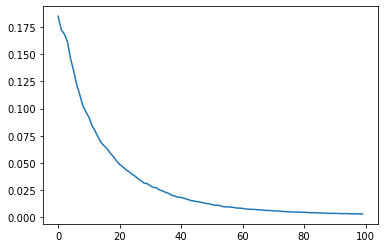

In [8]:
X = lire_alpha_digit(['X'])
p = len(X[0])
q = 100
Rbm = init_RBM(p,q)
Rbm,error = train_RBM(Rbm,X,0.1, 100, 3)
plt.plot(error)

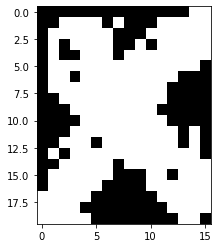

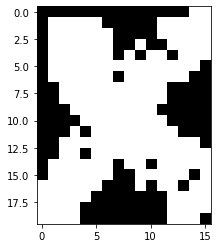

In [9]:
generer_image_RBM(Rbm, 500, 2)

# Construction d’un DBN et test sur Binary AlphaDigits

In [10]:
def init_DBN(config):
    for i in range(len(config)-1):
        if i == 0:
            DBN = [init_RBM(config[i], config[i+1])]
        else:
            DBN.append(init_RBM(config[i], config[i+1]))
    return DBN

def train_DBN(DBN, H, epsilon, epochs, batch_size):
    for i in range(len(DBN)):
            DBN[i],error = train_RBM(DBN[i], H, epsilon, epochs, batch_size)
            H = entree_sortie_RBM(DBN[i],H)
    return DBN

In [11]:
def generer_image_DBN(Dbm, nb_iter, nb_images):
    for i in range(nb_images):
        v_0 = np.random.uniform(0, 1, (1, config[0]))
        v_k = v_0
        for j in range(nb_iter):
            
            for y in range(0,len(Dbm)): 
                prob_h_given_v = entree_sortie_RBM(Dbm[y], v_k)
                v_k = (prob_h_given_v > np.random.rand(config[y+1])) * 1.0

            h_k = v_k
            for k in range(len(Dbm)-1, -1, -1):
                prob_v_given_h = sortie_entree_RBM(Dbm[k], h_k)
                h_k = (prob_v_given_h > np.random.rand(config[k])) * 1.0

            v_k = h_k

        image = np.reshape(v_k, (20, 16))
        plt.imshow(image, cmap='gray')
        plt.show()

In [12]:
config = [len(X[0]),100,50,100]
X  = lire_alpha_digit(['X'])
Dbm = init_DBN(config)
Dbm = train_DBN(Dbm, X, 0.1, 100, 3)

Epoch :  0 Erreur :  0.18271953649198086
Epoch :  10 Erreur :  0.09761023375270225
Epoch :  20 Erreur :  0.04781730672334792
Epoch :  30 Erreur :  0.02775661417939184
Epoch :  40 Erreur :  0.01742828229075545
Epoch :  50 Erreur :  0.011913689653811944
Epoch :  60 Erreur :  0.008432467447065675
Epoch :  70 Erreur :  0.006521382188542273
Epoch :  80 Erreur :  0.005170693734466484
Epoch :  90 Erreur :  0.003921055043899971
Epoch :  0 Erreur :  0.16342437290190387
Epoch :  10 Erreur :  0.11722015834197738
Epoch :  20 Erreur :  0.0640867351605961
Epoch :  30 Erreur :  0.038509443534083705
Epoch :  40 Erreur :  0.02302171061045492
Epoch :  50 Erreur :  0.016502689671795478
Epoch :  60 Erreur :  0.011537587595236489
Epoch :  70 Erreur :  0.008305779773810508
Epoch :  80 Erreur :  0.006143535317040049
Epoch :  90 Erreur :  0.005754204564733511
Epoch :  0 Erreur :  0.24763739513110755
Epoch :  10 Erreur :  0.1887379284608036
Epoch :  20 Erreur :  0.08548368975395143
Epoch :  30 Erreur :  0.0573

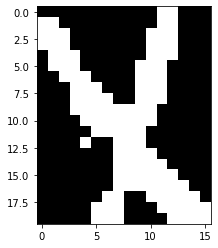

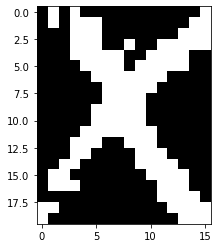

In [13]:
generer_image_DBN(Dbm, 500, 2)

# Construction d’un DNN et test sur MNIST

In [14]:
from principal_RBM_MNIST import init_RBM, entree_sortie_RBM,\
                                sortie_entree_RBM, train_RBM
# Définition de la classe DNN
class DNN:
    # Initialisation de la classe DNN avec 3 arguments: p, hidden_layers_units, nbr_classes
    def __init__(self, p, hidden_layers_units, nbr_classes):
        # Vérifie si hidden_layers_units contient au moins un élément
        if len(hidden_layers_units) == 0:
            # Si hidden_layers_units est vide, une exception ValueError est levée
            raise ValueError('Pas de hidden layers...')
        # Stocke les arguments en tant qu'attributs de la classe
        self.p = p
        self.nbr_classes = nbr_classes
        # Initialise layer_p avec la valeur de p
        layer_p = p
        # Initialise une liste vide pour stocker les RBM
        self.DBN = []
        # Parcours tous les éléments de hidden_layers_units
        for l, q in enumerate(hidden_layers_units):
            # Initialise un RBM avec p=layer_p et q=q, puis ajoute ce RBM à la liste DBN
            self.DBN.append(init_RBM(p=layer_p, q=q))
            # Met à jour la valeur de layer_p avec la valeur de q
            layer_p = q
        # Initialise un RBM pour la couche de classification avec p=layer_p et q=nbr_classes
        self.classification_layer = init_RBM(p=layer_p, q=nbr_classes)
        # Stocke le nombre de couches cachées dans l'attribut nbr_hidden_layers
        self.nbr_hidden_layers = len(self.DBN)
                
# fonction qui initialise un objet DNN avec les arguments donnés
def init_DNN(p, hidden_layers_units, nbr_classes):
    return DNN(p, hidden_layers_units, nbr_classes)



In [15]:
# fonction qui effectue une phase de pré-entraînement sur l'objet DNN donné avec les données X, 
# pendant un certain nombre d'époques, avec un taux d'apprentissage et une taille de batch donnés
def pretrain_DNN(dnn, X, epochs, learning_rate, batch_size):
    # Copie les données X dans v
    v = X.copy()
    # Parcours toutes les couches cachées de l'objet DNN
    for layer in range(dnn.nbr_hidden_layers):
        # Effectue une phase d'entraînement sur la couche RBM actuelle avec les données v, 
        # pendant un certain nombre d'époques, avec un taux d'apprentissage et une taille de batch donnés
        dnn.DBN[layer] = train_RBM(dnn.DBN[layer], v, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size, cd_k=1)
        # Calcule la sortie de la couche RBM actuelle et stocke cette sortie dans v
        _, v = entree_sortie_RBM(dnn.DBN[layer], v)
    # Retourne l'objet DNN avec les couches RBM pré-entraînées
    return dnn



In [16]:
# Cette fonction prend en entrée une RBM et une matrice d'entrée, et calcule la sortie
# softmax de la couche de classification.
def calcul_softmax(rbm_unit, data_entree):
    # Calcul de la sortie brute de la RBM.
    raw_output = data_entree @ rbm_unit.W + rbm_unit.b
    # Calcul des exponentielles de la sortie brute, avec une normalisation pour éviter les erreurs numériques.
    exps = np.exp(raw_output - np.max(raw_output, axis=1)[:, None])
    # Calcul de la sortie softmax.
    return exps / np.sum(exps, axis=1)[:, None], raw_output



In [17]:
# Cette fonction prend en entrée un réseau DNN et une matrice d'entrée, et calcule la sortie
# du réseau pour cette entrée.
def entree_sortie_reseau(dnn, data_entree):
    # Initialisation d'une liste pour stocker les sorties de chaque couche.
    outputs_reseau = []
    # Copie de la matrice d'entrée.
    v = data_entree.copy()
    # Boucle sur les couches cachées du DNN.
    for i in range(dnn.nbr_hidden_layers):
        # Calcul de la sortie de la couche cachée avec une RBM.
        v, _ = entree_sortie_RBM(dnn.DBN[i], v)
        # Stockage de la sortie de la couche cachée.
        outputs_reseau.append(v)
    # Calcul de la sortie de la couche de classification.
    class_probabilities, raw_classification_output = calcul_softmax(dnn.classification_layer, v)
    # Stockage de la sortie brute de la couche de classification et de la sortie softmax.
    outputs_reseau.append(raw_classification_output)
    outputs_reseau.append(class_probabilities)
    # Retourne la liste des sorties de chaque couche.
    return outputs_reseau

In [18]:
# Cette fonction calcule l'entropie croisée entre les prédictions et les cibles.
def cross_entropy(predictions, targets, epsilon=1e-12):
    # Limitation des prédictions pour éviter les erreurs de calcul.
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    # Calcul de la taille de l'échantillon.
    N = predictions.shape[0]
    # Calcul de l'entropie croisée.
    ce = -np.sum(targets * np.log(predictions + 1e-9)) / N
    return ce

def retropropagation(dnn, epochs, learning_rate, batch_size, X, y):
    loss_history = [] # Liste vide pour stocker les valeurs de la fonction de coût
    X_train = X.copy()
    y_train = y.copy()
    for epoch in range(epochs):
        X_train, y_train = shuffle(X_train, y_train) # On mélange les données
        loss = 0.
        n = X_train.shape[0]
        if batch_size > n:
            raise ValueError('Batch size > Train size') 
        for batch_start in range(0, n - batch_size, batch_size):
            x_batch = X_train[batch_start:batch_start + batch_size, :]  # Extraction des exemples pour le batch
            y_batch = y_train[batch_start:batch_start + batch_size, :]  # Extraction des labels pour le batch
            taille_batch = x_batch.shape[0]
            outputs_reseau = entree_sortie_reseau(dnn, x_batch)
            y_pred = outputs_reseau[-1]
            grads = {}
            c_p = y_pred - y_batch  # Calcul de la dérivée partielle de la fonction de coût par rapport aux sorties 
                                    # de la dernière couche
            x_l_minus_1 = outputs_reseau[-3] # Données d'entrée pour la dernière couche cachée
            grads[f'dW_softmax'] = (x_l_minus_1.T @ c_p)/taille_batch # Calcul du gradient de la dernière couche
                                                                      # de classification
            grads[f'db_softmax'] = np.mean(c_p, axis=0)
            c_l_plus_1 = c_p # Initialisation de la dérivée partielle de la fonction de coût par rapport aux sorties
                             # de la couche précédente
            # Parcourt sur les couches cachées du réseau de neurones partant de la dernière couche cachée à la première.
            for l in range(dnn.nbr_hidden_layers - 1, -1, -1):
                x_l = outputs_reseau[l] # récupèration de la sortie de la couche cachée actuelle.
                if l != 0:
                    x_l_minus_1 = outputs_reseau[l-1]
                else:
                    x_l_minus_1 = x_batch
                if l == dnn.nbr_hidden_layers - 1:
                    W_l_plus_1 = dnn.classification_layer.W
                else:
                    W_l_plus_1 = dnn.DBN[l+1].W
                c_l = (c_l_plus_1 @ W_l_plus_1.T)*(x_l*(1-x_l)) 
                c_l_plus_1 = c_l # mise à jour l'erreur pour la couche suivante.
                grads[f'dW_{l}'] = (x_l_minus_1.T @ c_l)/taille_batch # calcul des gradients pour la couche actuelle.
                grads[f'db_{l}'] = np.mean(c_l, axis=0)
            dnn.classification_layer.W -= learning_rate*grads['dW_softmax'] # Mise à jour du gradient
            dnn.classification_layer.b -= learning_rate*grads['db_softmax'] # Mise à jour du gradient
            for l in range(dnn.nbr_hidden_layers - 1, -1, -1):
                dnn.DBN[l].W -= learning_rate*grads[f'dW_{l}'] # Mise à jour des poids et biais de chaque couche cachée
                dnn.DBN[l].b -= learning_rate*grads[f'db_{l}']
        outputs_reseau = entree_sortie_reseau(dnn, X_train)  # Calcul de la perte sur les données d'entraînement
        prob_y_pred = outputs_reseau[-1]
        train_loss = cross_entropy(prob_y_pred, y_train)
        loss_history.append(train_loss)
    # Visualisation de la courbe de perte au fil des epochs
    f = plt.figure(figsize=(10, 7))
    plt.plot(range(epochs), loss_history)
    plt.legend(['Cross entropy'])
    plt.title("Cross entropy per epochs")
    plt.xlabel("epochs")
    plt.ylabel('Cross entropy')
    plt.show()
    return [dnn, loss_history]

In [19]:
def test_DNN(dnn, X_test, y_test):
    # Compute the outputs of the network for the test set
    outputs_reseau = entree_sortie_reseau(dnn, X_test)
    # Get the predicted labels from the network's output
    y_pred = outputs_reseau[-1]
    # Compute the cross-entropy loss for the test set
    test_loss = cross_entropy(y_pred, y_test)
    # Convert the predicted labels to one-hot encoding
    pred_labels = np.zeros_like(y_pred)
    pred_labels[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
    # Compute the accuracy of the predictions
    acc_test = np.sum((pred_labels == y_test).all(1))/pred_labels.shape[0]
    # Print the test loss and accuracy
    print(f'Test loss: {test_loss}, Acc. %: {100*acc_test}%')
    # Return the test loss and accuracy
    return test_loss, acc_test

In [20]:
# Load the MNIST data
from sklearn.model_selection import train_test_split
X, y = get_mnist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch: 0 -- Erreur de reconstruction: 0.07249271137026239
Epoch: 1 -- Erreur de reconstruction: 0.06284814595481049
Epoch: 2 -- Erreur de reconstruction: 0.05771560677842565
Epoch: 3 -- Erreur de reconstruction: 0.054426931486880464
Epoch: 4 -- Erreur de reconstruction: 0.05188379190962099
Epoch: 5 -- Erreur de reconstruction: 0.04988249362244898
Epoch: 6 -- Erreur de reconstruction: 0.04813103589650146
Epoch: 7 -- Erreur de reconstruction: 0.04678603316326531
Epoch: 8 -- Erreur de reconstruction: 0.0456488930393586
Epoch: 9 -- Erreur de reconstruction: 0.04447325983965015
Epoch: 10 -- Erreur de reconstruction: 0.04365588556851312
Epoch: 11 -- Erreur de reconstruction: 0.042760226858600585
Epoch: 12 -- Erreur de reconstruction: 0.042058764577259475
Epoch: 13 -- Erreur de reconstruction: 0.04142738702623907
Epoch: 14 -- Erreur de reconstruction: 0.04092246720116618
Epoch: 15 -- Erreur de reconstruction: 0.040317351494169096
Epoch: 16 -- Erreur de reconstruction: 0.03980883290816326
Epoc

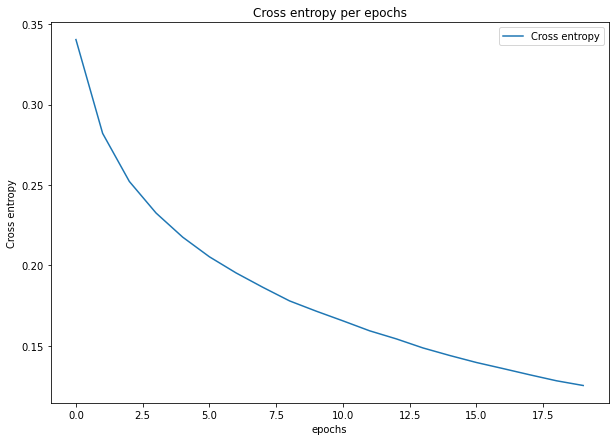

Test loss: 0.15158359645447153, Acc. %: 95.55714285714285%
Epoch: 0 -- Erreur de reconstruction: 0.07244631468658892
Epoch: 1 -- Erreur de reconstruction: 0.06290237791545189
Epoch: 2 -- Erreur de reconstruction: 0.05779644223760933
Epoch: 3 -- Erreur de reconstruction: 0.0543269861516035
Epoch: 4 -- Erreur de reconstruction: 0.05168920827259475
Epoch: 5 -- Erreur de reconstruction: 0.04967836643586006
Epoch: 6 -- Erreur de reconstruction: 0.04807361516034985
Epoch: 7 -- Erreur de reconstruction: 0.046706905976676386
Epoch: 8 -- Erreur de reconstruction: 0.04542911807580175
Epoch: 9 -- Erreur de reconstruction: 0.04440046465014577
Epoch: 10 -- Erreur de reconstruction: 0.043503621537900876
Epoch: 11 -- Erreur de reconstruction: 0.04284174562682216
Epoch: 12 -- Erreur de reconstruction: 0.04211276876822157
Epoch: 13 -- Erreur de reconstruction: 0.04136103771865889
Epoch: 14 -- Erreur de reconstruction: 0.04087486333819242
Epoch: 15 -- Erreur de reconstruction: 0.04039032889941691
Epoch:

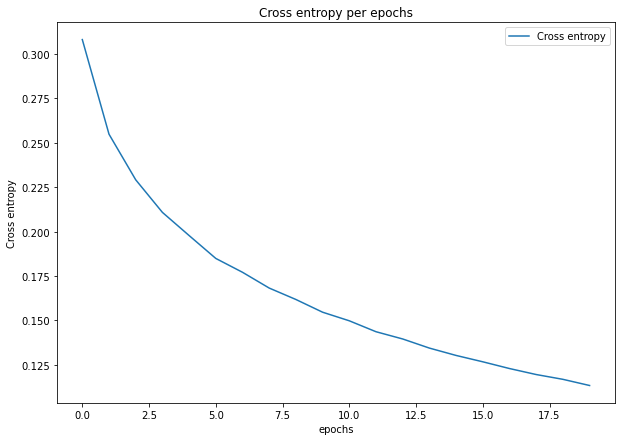

Test loss: 0.14339053875324068, Acc. %: 95.78571428571429%
Epoch: 0 -- Erreur de reconstruction: 0.07247699526239067
Epoch: 1 -- Erreur de reconstruction: 0.06317485878279884
Epoch: 2 -- Erreur de reconstruction: 0.05789600036443149
Epoch: 3 -- Erreur de reconstruction: 0.05460345298833819
Epoch: 4 -- Erreur de reconstruction: 0.05202250364431487
Epoch: 5 -- Erreur de reconstruction: 0.049994829628279884
Epoch: 6 -- Erreur de reconstruction: 0.04827872175655977
Epoch: 7 -- Erreur de reconstruction: 0.04691488247084548
Epoch: 8 -- Erreur de reconstruction: 0.045792228498542274
Epoch: 9 -- Erreur de reconstruction: 0.04466280976676385
Epoch: 10 -- Erreur de reconstruction: 0.04374697066326531
Epoch: 11 -- Erreur de reconstruction: 0.04295360331632653
Epoch: 12 -- Erreur de reconstruction: 0.04234413720845481
Epoch: 13 -- Erreur de reconstruction: 0.04171818057580175
Epoch: 14 -- Erreur de reconstruction: 0.04116763848396501
Epoch: 15 -- Erreur de reconstruction: 0.040630033709912534
Epoc

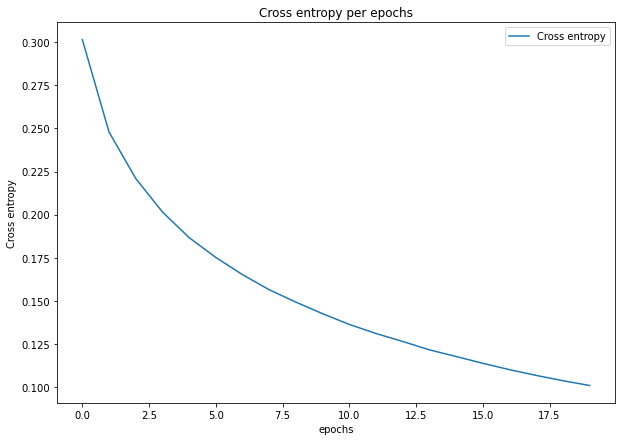

Test loss: 0.13407184571532726, Acc. %: 96.03571428571429%
Epoch: 0 -- Erreur de reconstruction: 0.07227701348396501
Epoch: 1 -- Erreur de reconstruction: 0.06309634657434403
Epoch: 2 -- Erreur de reconstruction: 0.05783516308309038
Epoch: 3 -- Erreur de reconstruction: 0.054184835094752186
Epoch: 4 -- Erreur de reconstruction: 0.05169649690233236
Epoch: 5 -- Erreur de reconstruction: 0.04972248542274053
Epoch: 6 -- Erreur de reconstruction: 0.047860650510204085
Epoch: 7 -- Erreur de reconstruction: 0.046602496355685134
Epoch: 8 -- Erreur de reconstruction: 0.045386160714285716
Epoch: 9 -- Erreur de reconstruction: 0.04428719478862974
Epoch: 10 -- Erreur de reconstruction: 0.0433938137755102
Epoch: 11 -- Erreur de reconstruction: 0.04282662172011662
Epoch: 12 -- Erreur de reconstruction: 0.04199282525510204
Epoch: 13 -- Erreur de reconstruction: 0.041415884657434406
Epoch: 14 -- Erreur de reconstruction: 0.04073861151603499
Epoch: 15 -- Erreur de reconstruction: 0.040254897048104955
Ep

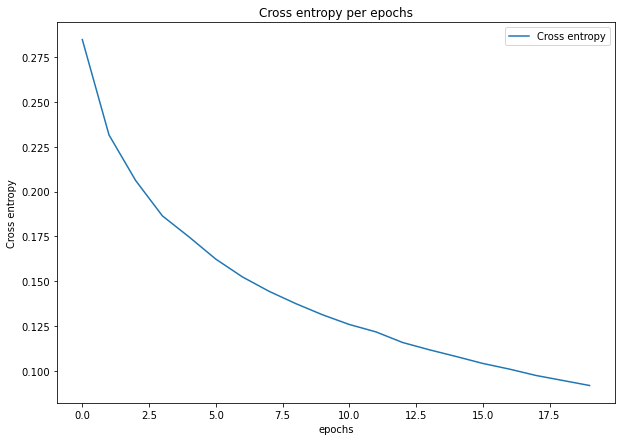

Test loss: 0.1284074020247695, Acc. %: 96.32142857142857%


In [21]:
p = 28*28
nbr_classes = y_train.shape[1]
events1 = []
events2 = []
hidden_layers_units = [[200, 200], [200, 200, 200], [200, 200, 200, 200], [200, 200, 200, 200, 200]]
for hidden_layers_units_loop in hidden_layers_units:
    dnn = init_DNN(p, hidden_layers_units_loop, nbr_classes)
    dnn = pretrain_DNN(dnn, X_train, epochs=20, learning_rate=0.1, batch_size=100) 
    dnn, train_loss = retropropagation(dnn, epochs=20, learning_rate=0.1, batch_size=100, X=X_train, y=y_train)
    events2.append(train_loss)
    test_loss, error_pct = test_DNN(dnn, X_test, y_test)

# Étude sur Binary AlphaDigit

In [22]:
from principal_DBN_alpha import *
# Spécification des paramètres liés au réseau et à l’apprentissage
input_size = 320  # Taille de l'entrée (20 x 16 pixels)
hidden_sizes = [25, 25]  # Nombre de neurones dans chaque couche cachée
output_size = 2  # Nombre de neurones en sortie (10 classes)
num_iters = 100  # Nombre d'itérations pour les descentes de gradient
learning_rate = 0.02  # Taux d'apprentissage
batch_size = 100  # Taille des mini-batch
num_train_data = 50000  # Nombre de données d'apprentissage
num_val_data = 200  # Nombre de données de validation
num_test_data = 200  # Nombre de données de test

# Charger les données
data = lire_alpha_digit(['0', '2', 'F', 'Z'])

# On fait un mélange les données aléatoirement (Shuffle)
random.shuffle(data)

# Filtration des données pour ne garder que les données d'apprentissage
train_data = data[:num_train_data] # sélection des num_train_data premières données de la liste data

Epoch :  0 Erreur :  0.19902271680020955
Epoch :  10 Erreur :  0.08746277505554441
Epoch :  20 Erreur :  0.05584419910637215
Epoch :  30 Erreur :  0.03989278639086666
Epoch :  40 Erreur :  0.030861065274524056
Epoch :  50 Erreur :  0.025167532700578248
Epoch :  60 Erreur :  0.020796545898600794
Epoch :  70 Erreur :  0.01747472139211543
Epoch :  80 Erreur :  0.014913717724902516
Epoch :  90 Erreur :  0.012941571337703425


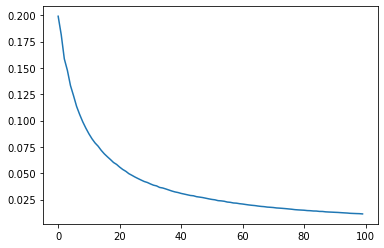

In [23]:
# Entrainement du RBM sur les données d'apprentissage
X = train_data
p = len(X[0])
q = 100
Rbm = init_RBM(p,q)
Rbm,error = train_RBM(Rbm,X,learning_rate, batch_size, output_size)
plt.plot(error)

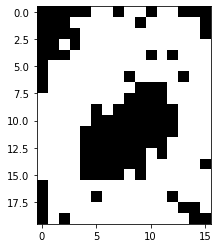

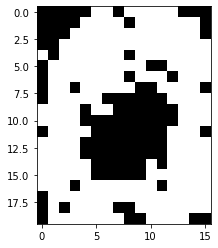

In [24]:
generer_image_RBM(Rbm, nb_iter = 500, nb_images = 2)

Epoch :  0 Erreur :  0.18654709332462038
Epoch :  10 Erreur :  0.08823836570515904
Epoch :  20 Erreur :  0.04721739104753765
Epoch :  30 Erreur :  0.027904685125566542
Epoch :  40 Erreur :  0.01791008799775358
Epoch :  50 Erreur :  0.011882632488675021
Epoch :  60 Erreur :  0.008353888869829436
Epoch :  70 Erreur :  0.0059055997952490984
Epoch :  80 Erreur :  0.004497915072813831
Epoch :  90 Erreur :  0.0035511768328765855
Epoch :  0 Erreur :  0.156791467648766
Epoch :  10 Erreur :  0.13873872738970613
Epoch :  20 Erreur :  0.06702195776942925
Epoch :  30 Erreur :  0.038859454550365144
Epoch :  40 Erreur :  0.025855451541506636
Epoch :  50 Erreur :  0.017525312789018307
Epoch :  60 Erreur :  0.011895374086183895
Epoch :  70 Erreur :  0.009030819449005929
Epoch :  80 Erreur :  0.007421173314298354
Epoch :  90 Erreur :  0.005381643154529781
Epoch :  0 Erreur :  0.2639216074792401
Epoch :  10 Erreur :  0.14956704137881605
Epoch :  20 Erreur :  0.07703870737641437
Epoch :  30 Erreur :  0.0

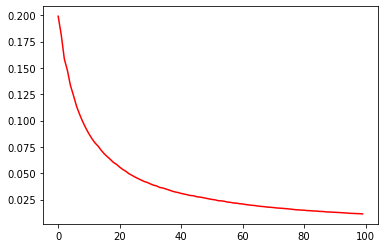

In [25]:
config = [len(X[0]),100,50,100]
X  = lire_alpha_digit(['X'])
Dbm = init_DBN(config)
Dbm = train_DBN(Dbm, X, 0.1, 100, 3)
plt.plot(error, 'red' )

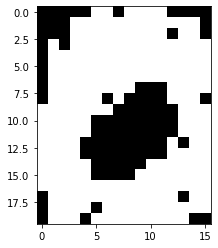

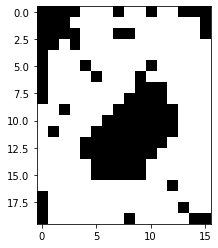

In [26]:
generer_image_RBM(Rbm, 500, 2)

# Étude à réaliser sur MNIST